<a href="https://colab.research.google.com/github/wayne1123/Topic/blob/master/Pixel_CNN_MNIST(simplified).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### (Very) Simplified Version of Pixel CNN

Pixel CNN paper -http://proceedings.mlr.press/v48/oord16.pdf

The purpose of this Notebook is to implement a very simple version of Pixel CNN with MNIST data set. 

The basic idea is very simple: Using the multiple stacked layers of masked convolutions, we can compute the $p(x_n|x_{i<n})$ for each pixel. Then, see how the model generates the images based on the first few information of pixels.

In [0]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [115]:

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

If we use 7x7 convolution layer and stack 9 layers, then the last pixel could receive the input from the first cell. 

In [116]:
!pip install torch

In [117]:
import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

1.0.1.post2


#### Masked convolution

Assume that the pixels here are represented as this.

x1 x2 x3 <br>
x4 x5 x6 <br>
x7 x8 x9

We want to express $x_5 = \sum_{i<5} x_i w_i$. Since it is a weighted sum of the past inputs, it can be re-written as the convolution with the masking layer as below.

1 1 1<br>
1 0  0 <br>
0 0  0 <br>
 
With this, we can easily implement the (simplified) Pixel CNN with the convolution block already implemented in the library(Pytorch).

First, define the **MaskedConv2d** function as below. 

In [0]:
class MaskedConv2d(nn.Conv2d):
  def __init__(self, *args, **kwargs):
    super(MaskedConv2d, self).__init__(*args, **kwargs)
    self.register_buffer('mask', self.weight.data.clone())
    _, _, HH, WW = self.weight.size()
    self.mask.fill_(1)
    self.mask[:,:,HH//2,WW//2:] = 0
    self.mask[:,:,HH//2+1:] = 0
    
  def forward(self, x):
    self.weight.data *= self.mask
    return super(MaskedConv2d, self).forward(x)


#### Overall Arichtecture

It is necessary for the last pixel of the input image to have the sufficient receptive field to view the image. Since MNIST is 28 x 28, then, the last pixel which is on (28, 28) needs to see the image.

I chose 7x7 convolutions to have the fewest layers as possible. On the position of (28, 28), the 7x7 convolution layers allows the pixel to receive the input from the above and left 3 pixels each. Then, we need 9 layers to view the whole image.

I use channels in arbitrary sense, but I believe there are 10 different types of images so 64 channels are enough. On the last layer, I use 1x1 convolution to decrease the number of channels into 1, then I use Sigmoid to get the probability.


I have not attempted to use Residual Connection, Batch Normalization - the original paper used those methods.

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = MaskedConv2d(1,2,7,padding=3)
    self.conv2 = MaskedConv2d(2,4,7,padding=3)
    self.conv3 = MaskedConv2d(4,8,7,padding=3)
    self.conv4 = MaskedConv2d(8,16,7,padding=3)
    self.conv5 = MaskedConv2d(16,32,7,padding=3)
    self.conv6 = MaskedConv2d(32,64,7,padding=3)
    self.conv7 = MaskedConv2d(64,64,7,padding=3)
    self.conv8 = MaskedConv2d(64,64,7,padding=3)
    self.conv9 = MaskedConv2d(64,64,7,padding=3)
    self.conv10 = nn.Conv2d(64,1,1)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()
  
  def forward(self, x):
    y = self.relu(self.conv1(x))
    y = self.relu(self.conv2(y))
    y = self.relu(self.conv3(y))
    y = self.relu(self.conv4(y))
    y = self.relu(self.conv5(y))
    y = self.relu(self.conv6(y))
    y = self.relu(self.conv7(y))
    y = self.relu(self.conv8(y))
    y = self.relu(self.conv9(y))
    out = self.conv10(y)
    return self.sigmoid(out) 

In [0]:
x_train = torch.from_numpy(x_train).cuda()
x_test = torch.from_numpy(x_test).cuda()

#### Loss : Binary Crossentropy

I use Binary Crossentropy which is the same as minimizing the Negative Log likelihood of the data set. 

In [0]:
def bce_loss(recon_x, x):
  bce = nn.BCELoss(size_average=True)
  return bce(recon_x, x)

#### Training

I chose the batch size as 250 which is common for MNIST classification tasks. The optimizer is Adam Optimizer which is also common in nowadays, without any decays on the learning rate. 

In [0]:
batch_size = 250
iter_per_batch = x_train.shape[0] // batch_size
def train(model, optimizer, n_epoch=10):
  losses = []
  for epoch in range(n_epoch):
    for i in range(iter_per_batch):
      x_ = x_train[i*batch_size:(i+1)*batch_size].reshape(-1,1,28,28)
      x_ = x_.float()
      optimizer.zero_grad()
      outs = model(x_)
      loss = bce_loss(outs, x_)
      loss.backward()
      optimizer.step()
      losses.append(loss)
    print("epoch : ", epoch, " loss : ", losses[-1])
  return losses

#### Test

There are two different kinds of test - one is just to generate the image based on the input, and the other is to generate the image based on the occluded inputs.

In [0]:
def test(model, x_test_c, n_idx=10, n_masked=300):
  idx = np.random.choice(x_test_c.shape[0], n_idx)
  x_test_c = x_test_c.float()
  x_test = x_test_c[idx].clone()
  x_test = x_test.reshape(-1,1,28,28)
  x_test.reshape(-1,784)[:,(784-n_masked):] = 0
  x_pred = torch.zeros(x_test.size())
  with torch.no_grad():
    x_pred1 = model(x_test_c[idx].reshape(-1,1,28,28))
    x_pred2 = model(x_test)
    x_test.reshape(n_idx,-1)[:,:(784-n_masked)] = x_pred2.reshape(n_idx,-1)[:,:(784-n_masked)]
    for i in range(1,n_masked):
      x_pred2 = model(x_test)
      x_test.reshape(n_idx,-1)[:,784-n_masked+i] = x_pred2.reshape(n_idx,-1)[:,784-n_masked+i]
  return x_pred1, x_test, idx

#### Now, it is time to run the model

In [0]:
cnn1 = CNN().cuda()
optimizer1 = optim.Adam(cnn1.parameters(), lr=1e-3)

In [140]:
ls = train(cnn1, optimizer1, n_epoch=50)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


epoch :  0  loss :  tensor(0.2726, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch :  1  loss :  tensor(0.2628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch :  2  loss :  tensor(0.2441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch :  3  loss :  tensor(0.2301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch :  4  loss :  tensor(0.2120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch :  5  loss :  tensor(0.2003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch :  6  loss :  tensor(0.1905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch :  7  loss :  tensor(0.1841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch :  8  loss :  tensor(0.1800, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch :  9  loss :  tensor(0.1770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch :  10  loss :  tensor(0.1745, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch :  

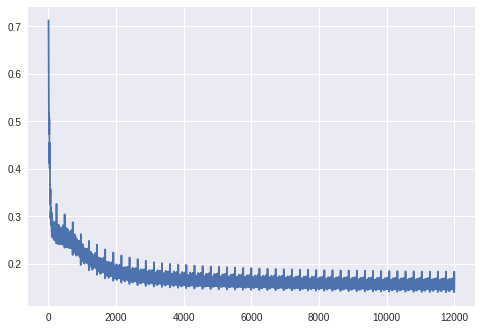

In [144]:
plt.plot(ls)

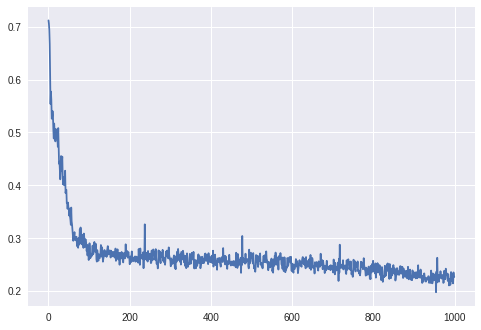

In [167]:
plt.plot(ls[:1000])

#### See how it works with the occluded images


* Orginal: Original Image
* Generated: Generate the image based on the whole imput image
* Occluded: Generate the image based on the occluded imput images (last 150/250/350/450 masked respectively)

In [0]:
preds1_4, preds2_4, idx_4 = test(cnn1,x_test, n_masked=450)
preds1_3, preds2_3, idx_3 = test(cnn1,x_test, n_masked=350)
preds1_2, preds2_2, idx_2 = test(cnn1,x_test, n_masked=250)
preds1_1, preds2_1, idx_1 = test(cnn1,x_test, n_masked=150)

In [0]:
def draw_samples(idx, x_test, preds1, preds2):
  for i in range(10):
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(x_test.cpu()[idx[i]])
    plt.subplot(1,3,2)
    plt.title("Generated")
    plt.imshow(preds1.cpu().numpy()[i].reshape(28,28))
    plt.subplot(1,3,3)
    plt.title("From Occluded")
    plt.imshow(preds2.cpu().numpy()[i].reshape(28,28))
    plt.show()

#### Last 150 Masked

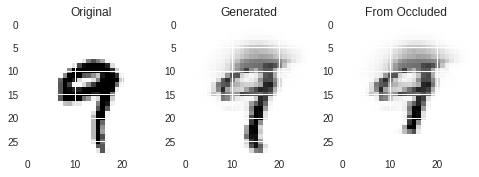

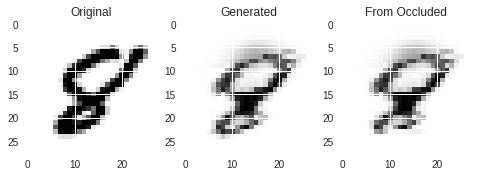

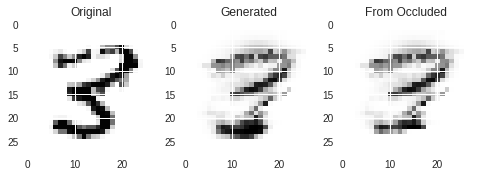

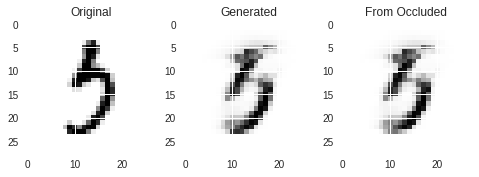

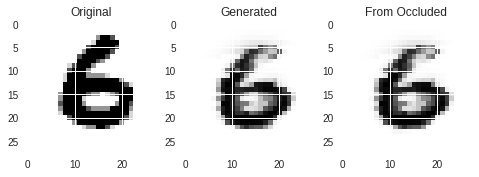

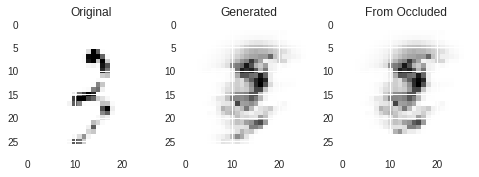

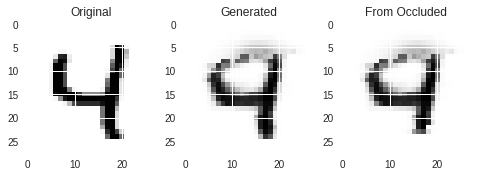

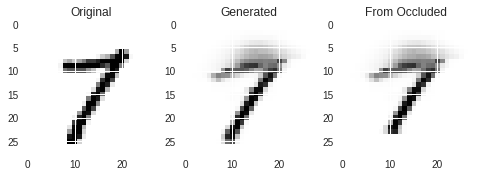

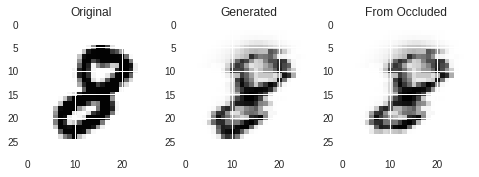

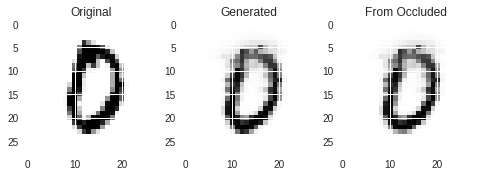

In [175]:
draw_samples(idx_1, x_test, preds1_1, preds2_1)

#### Last 250 masked

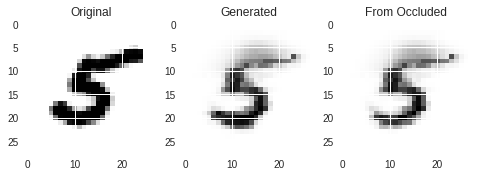

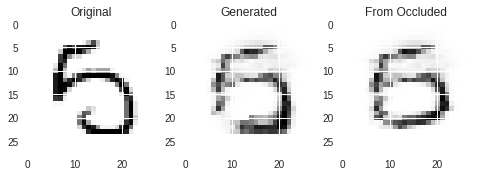

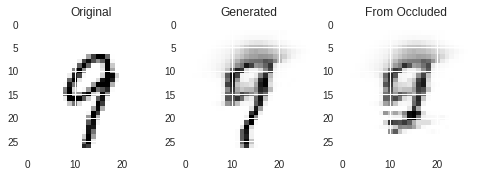

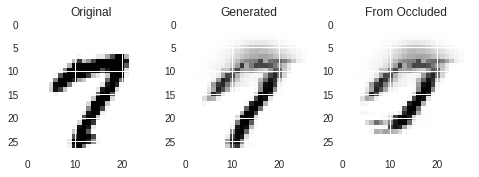

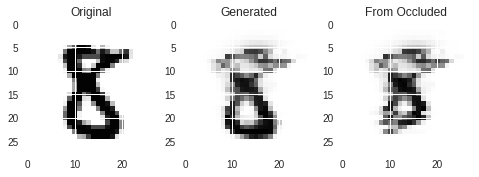

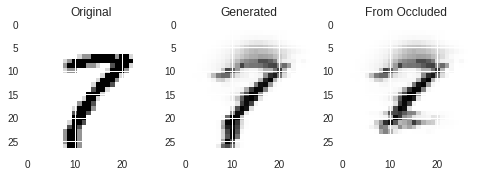

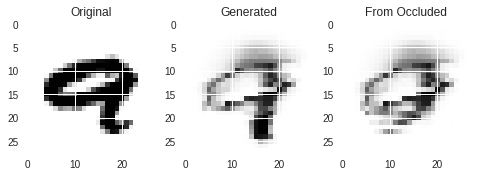

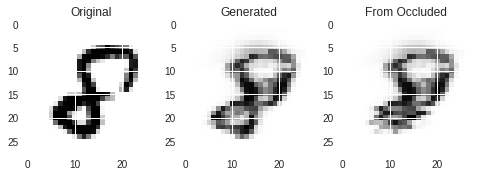

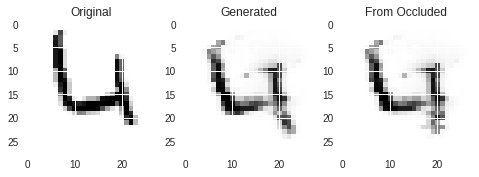

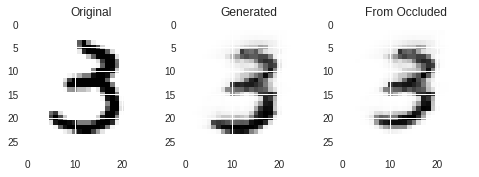

In [176]:
draw_samples(idx_2, x_test, preds1_2, preds2_2)

#### Last 350 masked

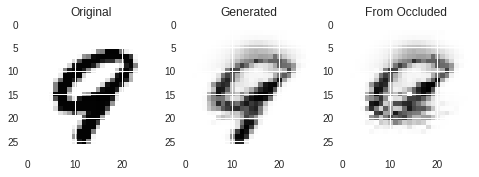

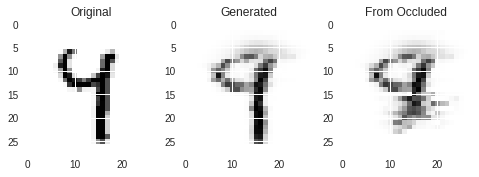

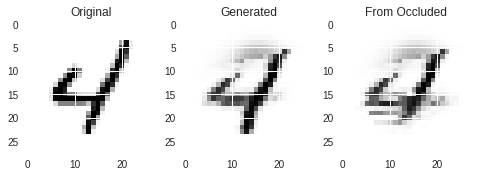

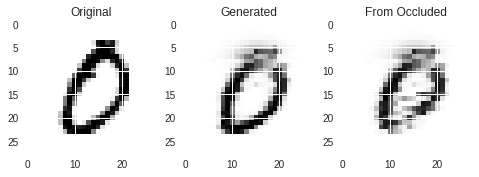

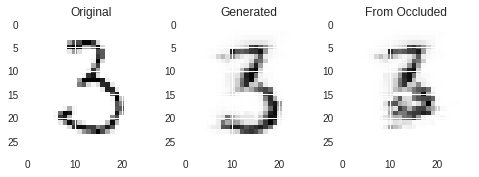

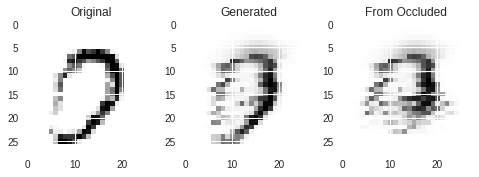

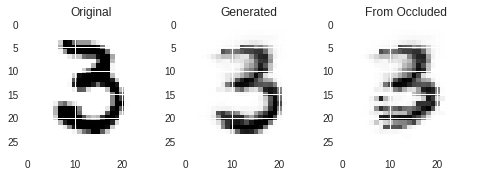

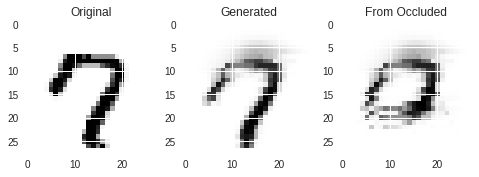

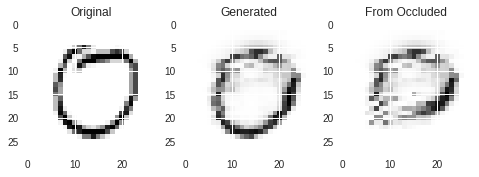

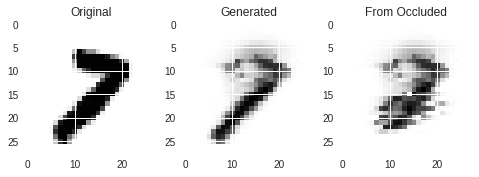

In [177]:
draw_samples(idx_3, x_test, preds1_3, preds2_3)

#### Last 450 masked

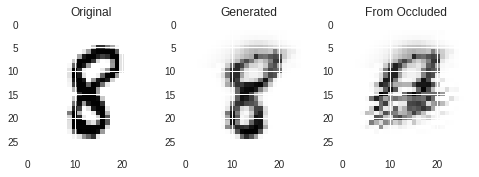

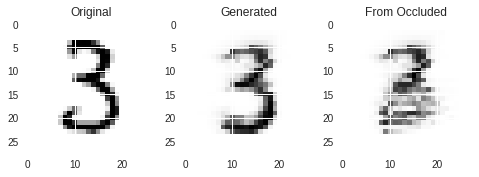

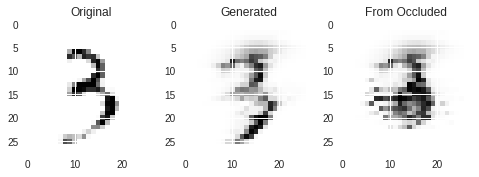

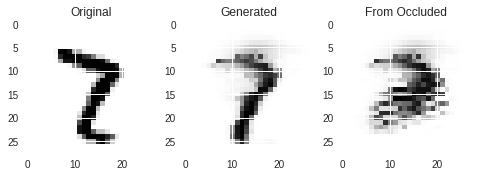

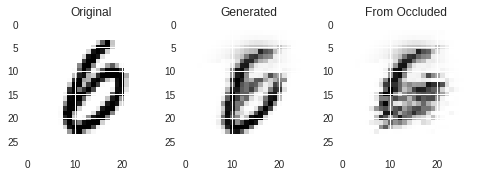

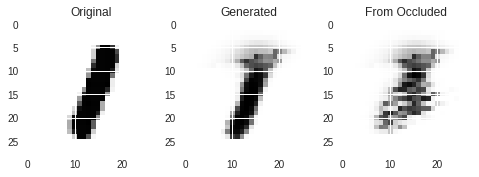

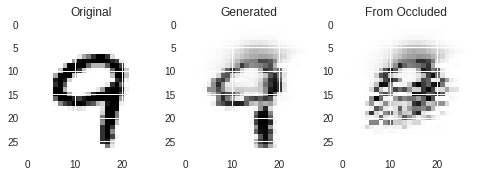

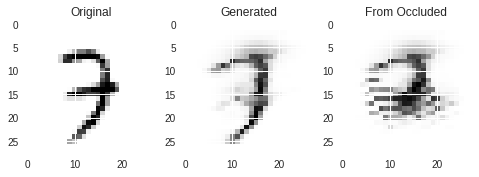

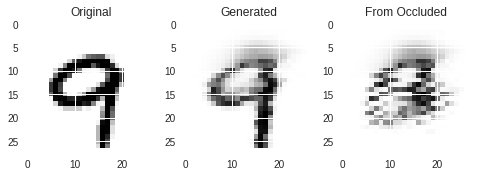

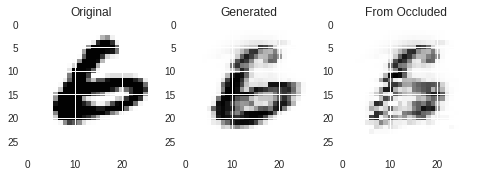

In [178]:
draw_samples(idx_4, x_test, preds1_4, preds2_4)

### Conclusion

We have seen that the results are not very good as we mask more pixels. It may require more sophisticated methods for training such as skipping, batch normalization and more layers. However, we can see the potential for generating $p(x_t|x_{i<t})$. 